In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import xgboost as xgb
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_excel('vle_nptc.xlsx')
df.head()

,m1,sigma1,epsilon1,kappa_ab1,epsilon_ab1,NA_1,NB_1,m2,sigma2,epsilon2,kappa_ab2,epsilon_ab2,NA_2,NB_2,x1,T/K,P/Pa,y1,y_exp
0,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.068,373.124,334396.0,0.036339,0.031
1,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.174,373.124,311643.0,0.090161,0.089
2,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.333,373.124,281996.0,0.167015,0.176
3,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.478,373.124,250969.0,0.237391,0.250
4,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.719,373.124,204774.0,0.381351,0.381


In [ ]:
X = df[['m1','sigma1','epsilon1','kappa_ab1','epsilon_ab1','NA_1','NB_1',
        'm2','sigma2','epsilon2','kappa_ab2','epsilon_ab2','NA_2','NB_2',
        'T/K','P/Pa','x1']].values
y = df[['y1']].values


array([0.068, 0.174, 0.333, 0.478, 0.719, 0.879, 0.926, 0.947, 0.965,
       0.989])

In [4]:
from sklearn.model_selection import train_test_split
X_new,X_val,y_new,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint,uniform,loguniform

In [30]:
advanced_param_dist = {
    'n_estimators': randint(50, 400),
    'max_depth': randint(3, 8),
    'learning_rate': loguniform(0.01, 0.15),  
    'subsample': uniform(0.5, 0.4),
    'colsample_bytree': uniform(0.6, 0.3),
    'colsample_bylevel': uniform(0.7, 0.2),  
    'colsample_bynode': uniform(0.7, 0.2),   
    'reg_alpha': loguniform(0.1, 20),
    'reg_lambda': loguniform(0.1, 30),
    'min_child_weight': randint(2, 10),
    'gamma': loguniform(0.01, 1.0),
    'max_delta_step': randint(1, 5),  

}

# 精细搜索
advanced_search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, objective='reg:squarederror',eval_metric = ['mae','rmse']),
    advanced_param_dist,
    n_iter=100,  
    cv=6,
    scoring='r2',

    n_jobs=-1,
    random_state=42,
    verbose=1,
    return_train_score=True
)

advanced_search.fit(X_new, y_new)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


RandomizedSearchCV(cv=6,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=['mae', 'rmse'],
                                          feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025C44DDF820>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025C44E309A0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025C44DDF7F0>},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=1)

In [31]:
print("Best parameters:", advanced_search.best_params_)
print("Best score:", advanced_search.best_score_)

Best parameters: {'colsample_bylevel': 0.897251399173363, 'colsample_bynode': 0.8073181291974665, 'colsample_bytree': 0.8772125277322299, 'gamma': 0.029664229076429915, 'learning_rate': 0.07830273177800817, 'max_delta_step': 2, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 203, 'reg_alpha': 0.12145325265378748, 'reg_lambda': 0.42200434284851335, 'subsample': 0.7853398343538209}
Best score: 0.9265833452808746


In [32]:
best_params = advanced_search.best_params_
xgb_reg = xgb.XGBRegressor(**best_params,random_state = 42,
            objective = 'reg:squarederror', eval_metric=['rmse', 'mae'])
xgb_reg.fit(X_new,y_new,
            eval_set = [(X_val, y_val)],
            verbose=10)

[0]	validation_0-rmse:0.21118	validation_0-mae:0.16594
[10]	validation_0-rmse:0.11965	validation_0-mae:0.09027
[20]	validation_0-rmse:0.08224	validation_0-mae:0.05816
[30]	validation_0-rmse:0.06370	validation_0-mae:0.04396
[40]	validation_0-rmse:0.05606	validation_0-mae:0.03912
[50]	validation_0-rmse:0.05281	validation_0-mae:0.03657
[60]	validation_0-rmse:0.04917	validation_0-mae:0.03378
[70]	validation_0-rmse:0.04757	validation_0-mae:0.03246
[80]	validation_0-rmse:0.04728	validation_0-mae:0.03228
[90]	validation_0-rmse:0.04689	validation_0-mae:0.03208
[100]	validation_0-rmse:0.04638	validation_0-mae:0.03178
[110]	validation_0-rmse:0.04577	validation_0-mae:0.03154
[120]	validation_0-rmse:0.04577	validation_0-mae:0.03153
[130]	validation_0-rmse:0.04535	validation_0-mae:0.03126
[140]	validation_0-rmse:0.04448	validation_0-mae:0.03060
[150]	validation_0-rmse:0.04422	validation_0-mae:0.03043
[160]	validation_0-rmse:0.04421	validation_0-mae:0.03044
[170]	validation_0-rmse:0.04420	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.897251399173363,
             colsample_bynode=0.8073181291974665,
             colsample_bytree=0.8772125277322299, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['rmse', 'mae'], feature_types=None,
             feature_weights=None, gamma=0.029664229076429915, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07830273177800817, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
             max_depth=4, max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=203,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
y1_pred_train = xgb_reg.predict(X_new)
y1_pred_test = xgb_reg.predict(X_val)
rmse_train = mean_squared_error(y_new,y1_pred_train,squared = False)
rmse_test = mean_squared_error(y_val,y1_pred_test,squared = False)
print(f"rmse_train = {rmse_train} , rmse_test = {rmse_test}")
r2_train = r2_score(y_new,y1_pred_train)
r2_test = r2_score(y_val,y1_pred_test)
print(f"r2_train = {r2_train} , r2_test = {r2_test}")
mae_train = mean_absolute_error(y_new,y1_pred_train)
mae_test = mean_absolute_error(y_val,y1_pred_test)
print(f"mae_train = {mae_train} , mae_test = {mae_test}")

rmse_train = 0.035639724348888235 , rmse_test = 0.04426557901723304
r2_train = 0.9733825500300753 , r2_test = 0.957371357853505
mae_train = 0.02406156054532177 , mae_test = 0.030365767758320134


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


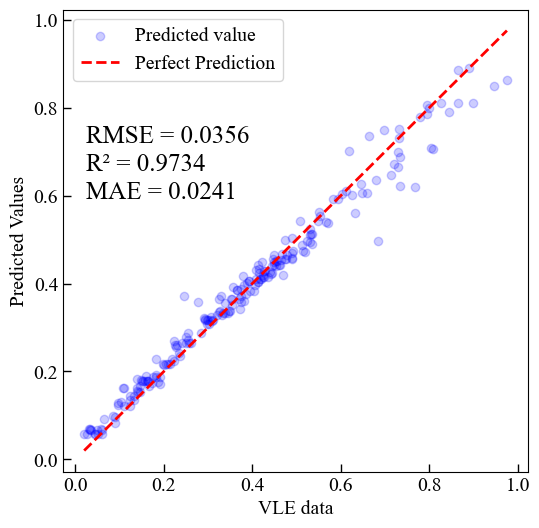

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.family'] = 'Times New Roman'  # 设置全局字体为 Times New Roman
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'stix'  # 使用 STIX 字体渲染 LaTeX 数学公式
ax.scatter(x=y_new, y=y1_pred_train, color='blue',alpha=0.2,label = "Predicted value")
ax.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel(R'VLE data')
ax.set_ylabel(R'Predicted Values')
rmse = rmse_train
r2 = r2_train
mae = mae_train
textstr = f'RMSE = {rmse:.4f}\nR² = {r2:.4f}\nMAE = {mae:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# 将文本框放置在图的右上角
ax.text(0.05, 0.75, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top')



# plt.title('True Values vs Predicted Values with Regression Line')
ax.tick_params(axis='both', direction='in', length=6, width=1)
ax.legend()

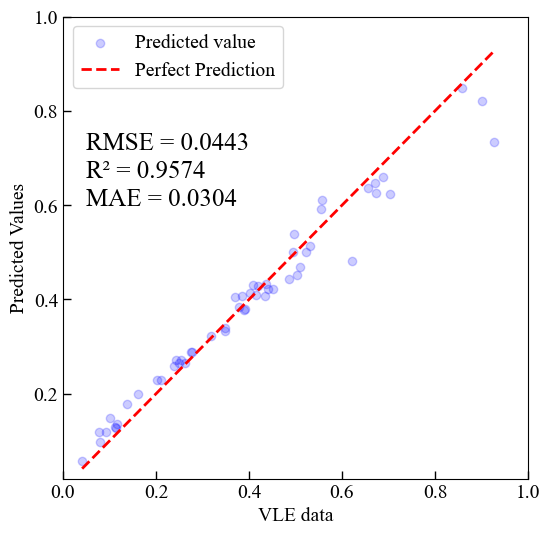

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.family'] = 'Times New Roman'  # 设置全局字体为 Times New Roman
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'stix'  # 使用 STIX 字体渲染 LaTeX 数学公式
ax.scatter(x=y_val, y=y1_pred_test, color='blue',alpha=0.2,label = "Predicted value")
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel(R'VLE data')
ax.set_ylabel(R'Predicted Values')
# plt.title('True Values vs Predicted Values with Regression Line')
ax.set_ylim(0.02,1)
ax.set_xlim(0,1)
rmse = rmse_test
r2 = r2_test
mae = mae_test
textstr = f'RMSE = {rmse:.4f}\nR² = {r2:.4f}\nMAE = {mae:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# 将文本框放置在图的右上角
ax.text(0.05, 0.75, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top')
ax.tick_params(axis='both', direction='in', length=6, width=1)
ax.legend()

In [36]:
import time
start_time = time.time()

y_pred = xgb_reg.predict(X)

end_time = time.time()
time_cost = end_time-start_time
print(f"the running time: {time_cost}")


the running time: 0.0010807514190673828


In [37]:
results_df = pd.DataFrame(X)
results_df['y_pred'] = y_pred

# 写入 CSV 文件
results_df.to_csv('XGBoost_predictions.csv', index=False)